# Seleccion de K y Clustering con K-Means

## Objetivos del Cuaderno

1. **Selección del Número de Clusters (K)**: Probar diferentes metodos para obtener valores de K y determinar el número óptimo de clusters.
    - **Método del Codo**: Graficar la inercia en función de K y buscar el "codo" en la gráfica.
    - **Silhouette Score**: Calcular el coeficiente de silueta para diferentes valores de K y graficar los resultados.
    - **Davies-Bouldin Index**: Calcular el índice de Davies-Bouldin para diferentes valores de K y graficar los resultados.
    - **K-ISAC-TLP**: Utilizar el método K-ISAC-TLP para determinar el número óptimo de clusters.
        - **ISAC Curves**: Graficar las curvas ISAC para diferentes valores de K y observar la tendencia.
        - **MAE**: Calcular el error absoluto medio (MAE) para diferentes valores de K y graficar los resultados.
        - **Irrelevant clusters**: Identificar y eliminar clusters irrelevantes que no aporten información significativa.
2. **Clustering con K-Means**: Aplicar el algoritmo de K-Means para agrupar las viviendas en función de sus patrones de consumo energético.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import random
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, davies_bouldin_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')

## Selección del Número de Clusters (K)

La elección del número óptimo de clusters (K) es un paso crucial en el algoritmo K-Means. Un valor de K demasiado bajo puede agrupar datos inherentemente distintos, mientras que un valor demasiado alto puede dividir clusters significativos o crear clusters con muy pocos miembros.

En este análisis, evaluamos varios valores de K dentro de un rango predefinido (2 a 20) utilizando las siguientes métricas:

* **Error Absoluto Medio (MAE):** Mide la distancia promedio entre cada punto y el centroide de su cluster asignado. Un MAE más bajo indica una mejor representación de los datos por los clusters.

* **Índice de Silueta:** Evalúa qué tan bien cada punto se ajusta a su propio cluster en comparación con otros clusters. Varía de -1 a 1, donde:
    * 1 indica que el punto está bien agrupado.
    * 0 indica que el punto está cerca del límite de decisión entre dos clusters.
    * -1 indica que el punto podría estar mejor en el cluster vecino.

* **Índice de Davies-Bouldin (DBI):** Mide la similitud promedio entre cada cluster y su cluster "más similar". Un DBI más bajo indica una mejor separación entre clusters.

* **Clusters Irrelevantes:** Contamos el número de clusters cuyo tamaño es menor que un umbral definido (1% del total de datos). Estos clusters pequeños pueden indicar un sobreajuste o ruido en los datos.

**Metodología:**

1.  **Carga de Datos:** Se carga el dataset preprocesado y escalado (StandardScaler).
2.  **Iteración sobre Valores de K:** Para cada valor de K en el rango especificado:
    * Se instancia y entrena un modelo KMeans con el valor de K actual.
    * Se obtienen las etiquetas de los clusters y los centroides.
    * Se calculan las métricas MAE, Índice de Silueta y DBI.
    * Se cuenta el número de clusters irrelevantes.
3.  **Almacenamiento de Resultados:** Los valores de K y las métricas correspondientes se guardan en archivos pickle para su posterior análisis o visualización.

**Interpretación de las Métricas:**

* Se busca un valor de K que minimice el MAE y el DBI, y maximice el Índice de Silueta.
* Un número elevado de clusters irrelevantes sugiere que K es demasiado grande.
* El "codo" en la gráfica de MAE puede indicar un valor de K adecuado, donde la disminución del error comienza a estabilizarse.
* El Índice de Silueta cercano a 1 indica que los clusters están bien separados.
* El Índice de Davies-Bouldin bajo indica que los clusters son distintos y compactos.

In [3]:
X = df.values

# Rango de valores de K a evaluar
k_values = range(2, 30)

MAE_values = []
silhouette_values = []
dbi_values = []
irreleCluster_values = []
wcss_values = []

# Umbral para considerar un cluster irrelevante (3% del total de datos)
threshold_percent = 5
min_cluster_size = len(X) * threshold_percent / 100

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    mae = mean_absolute_error(X, centroids[labels])
    MAE_values.append(mae)

    silhouette = silhouette_score(X, labels)
    silhouette_values.append(silhouette)

    dbi = davies_bouldin_score(X, labels)
    dbi_values.append(dbi)

    unique_labels, counts = np.unique(labels, return_counts=True)
    irrele_clusters = sum(counts < min_cluster_size)
    irreleCluster_values.append(irrele_clusters)

    wcss_values.append(kmeans.inertia_)


Guardar resultados

In [4]:
with open('pkls/k_values.pkl', 'wb') as f:
    pickle.dump(list(k_values), f)

with open('pkls/mae_values.pkl', 'wb') as f:
    pickle.dump(MAE_values, f)

with open('pkls/silhouette_values.pkl', 'wb') as f:
    pickle.dump(silhouette_values, f)

with open('pkls/dbi_values.pkl', 'wb') as f:
    pickle.dump(dbi_values, f)

with open('pkls/irreleCluster_values.pkl', 'wb') as f:
    pickle.dump(irreleCluster_values, f)

with open('pkls/wcss_values.pkl', 'wb') as f:
    pickle.dump(wcss_values, f)

### Analisis de Resultados

El siguiente paso consiste en analizar los resultados (valores de MAE, Índice de Silueta, DBI y número de clusters irrelevantes) para determinar el valor óptimo de K. Esto puede implicar la visualización de las métricas en función de K y la selección del valor que proporcione el mejor equilibrio entre las diferentes métricas.  Posteriormente, se podría aplicar un algoritmo como ISAC para refinar aún más la selección de K.

In [5]:
with open('pkls/k_values.pkl', 'rb') as f:
    k_values = pickle.load(f)

with open('pkls/mae_values.pkl', 'rb') as f:
    MAE_values = pickle.load(f)

with open('pkls/silhouette_values.pkl', 'rb') as f:
    silhouette_values = pickle.load(f)

with open('pkls/dbi_values.pkl', 'rb') as f:
    dbi_values = pickle.load(f)

with open('pkls/irreleCluster_values.pkl', 'rb') as f:
    irreleCluster_values = pickle.load(f)

with open('pkls/wcss_values.pkl', 'rb') as f:
    wcss_values = pickle.load(f)

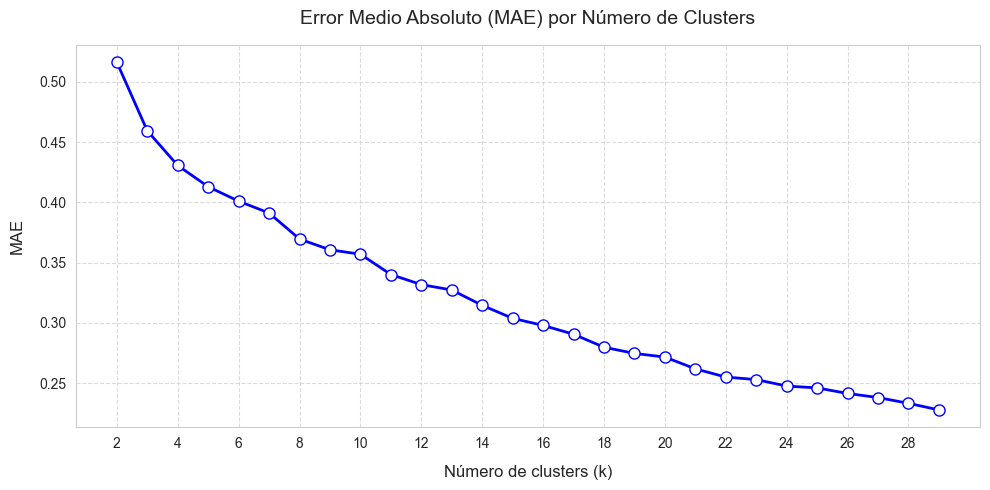

In [6]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, MAE_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Error Medio Absoluto (MAE) por Número de Clusters', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('MAE', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

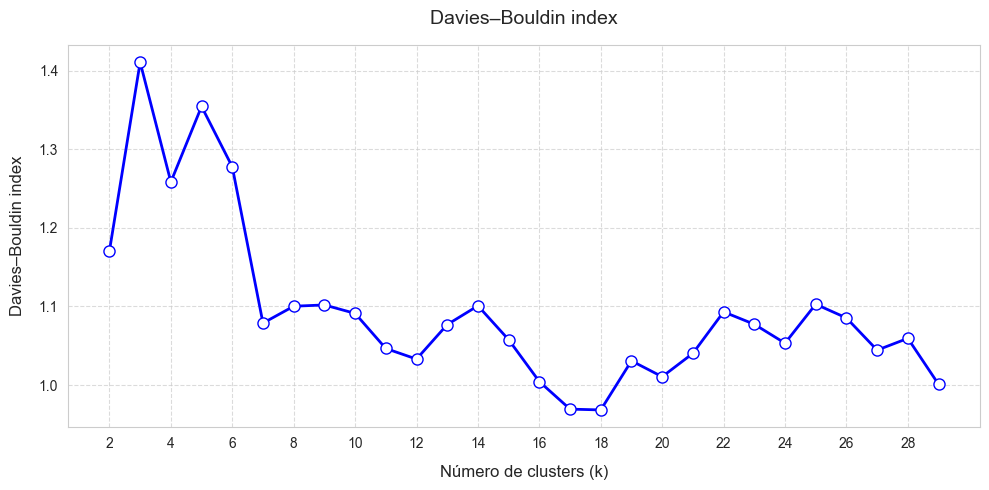

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, dbi_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Davies–Bouldin index', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Davies–Bouldin index', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

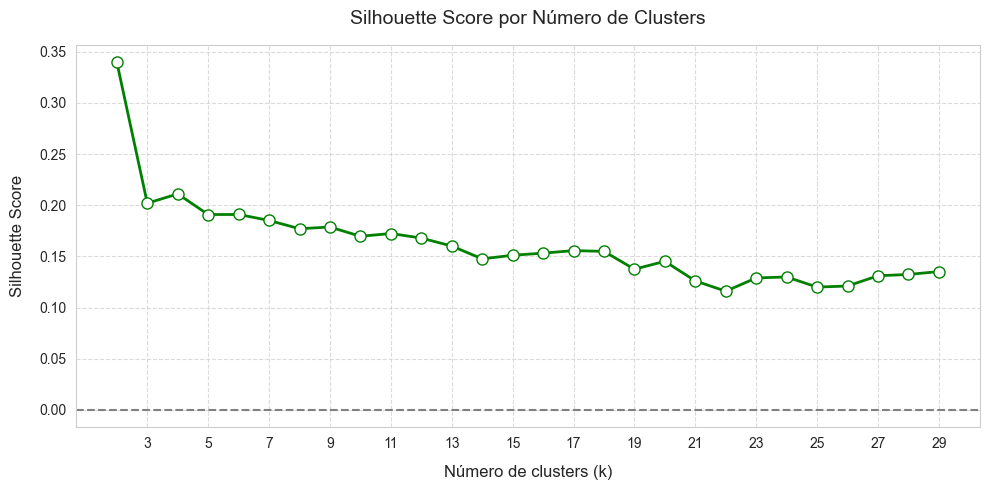

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, silhouette_values, 'go-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Silhouette Score por Número de Clusters', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Silhouette Score', labelpad=10, fontsize=12)
plt.xticks(k_values[1::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.axhline(y=0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

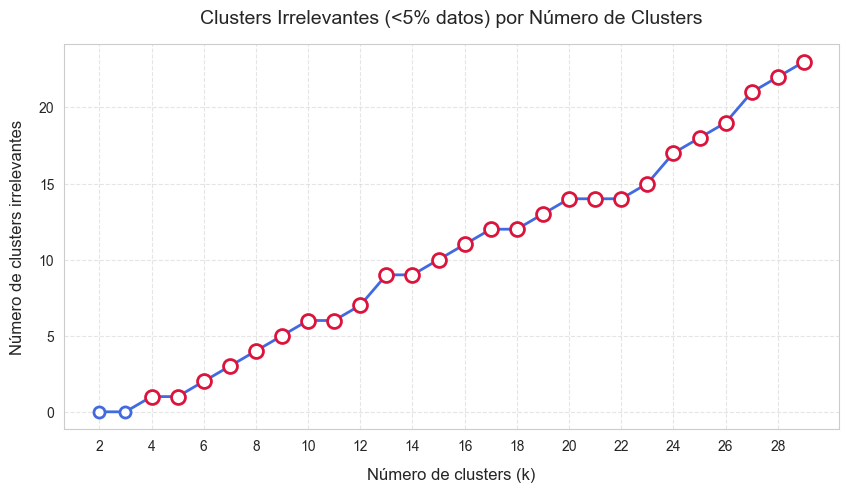

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, irreleCluster_values, 'o-', 
         color='royalblue', 
         markersize=8,
         markerfacecolor='white',
         markeredgewidth=2,
         linewidth=2)
for k, count in zip(k_values, irreleCluster_values):
    if count > 0:
        plt.plot(k, count, 'o', 
                 color='crimson', 
                 markersize=10,
                 markerfacecolor='white',
                 markeredgewidth=2)
plt.title('Clusters Irrelevantes (<5% datos) por Número de Clusters', 
          pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('Número de clusters irrelevantes', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.5)

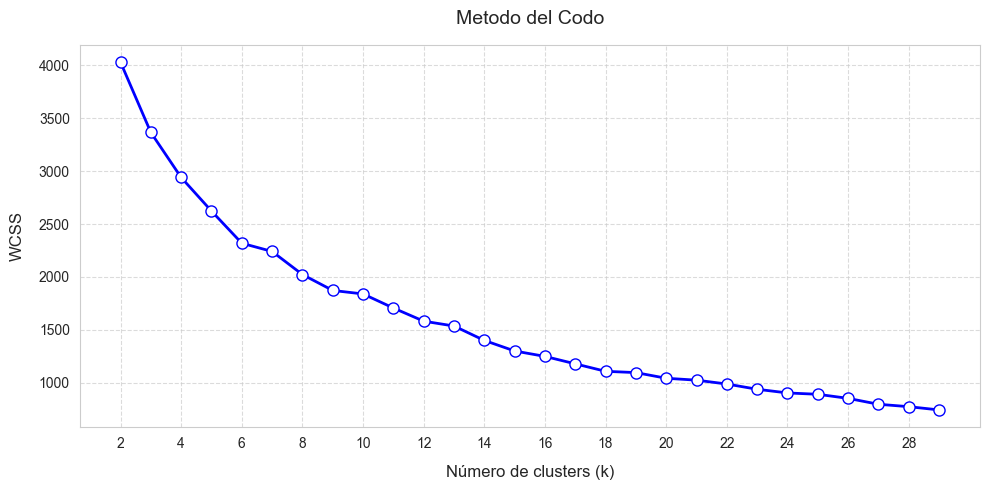

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

plt.plot(k_values, wcss_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='white')
plt.title('Metodo del Codo', pad=15, fontsize=14)
plt.xlabel('Número de clusters (k)', labelpad=10, fontsize=12)
plt.ylabel('WCSS', labelpad=10, fontsize=12)
plt.xticks(k_values[::2])
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

## Algorithm K-ISAC_TLP procedure
**Input:**
```python
// DATA: values for 𝑘 to be considered in the range
// defined by the experts
𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥] = 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
// DATA: List with MAE values measured for different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
// DATA: List with the number of irrelevant clusters modeled for
// different 𝑘 values
// For simplicity, assume that indexes are named 𝑘𝑚𝑖𝑛, 𝑘𝑚𝑖𝑛 + 1, ..., 𝑘𝑚𝑎𝑥
𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠[𝑘𝑚𝑖𝑛, 𝑘𝑚𝑎𝑥]
```
**Output:**
```python
// values for 𝑘 that meet the criteria defined by experts
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[]
```
**Procedure:**
```python
// Configure parameters before calling ISAC method
𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠 ← 3;
𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ← 3;
// Area threshold for MAE curve
𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝐴𝑟ｅ𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                                           𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠);
// Slope threshold for MAE curve
𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒𝐴𝑑𝑎𝑝𝑡𝑖𝑣𝑒𝑆𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠,
                                            𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠);
// Area threshold for curve with number of irrelevant clusters
𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 1.5;
// Slope threshold for curve with number of irrelevant clusters (degrees)
𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑 ← 22.5;
// Variables to store best 𝑘 values for every curve
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑀𝐴𝐸_𝑣𝑎𝑙𝑢𝑒𝑠,
                     𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                     𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                     𝑀𝐴𝐸_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑀𝐴𝐸_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[] ← 𝐼𝑆𝐴𝐶(𝑘_𝑣𝑎𝑙𝑢𝑒𝑠, 𝑖𝑟𝑟𝑒𝑙𝐶𝑙𝑢𝑠𝑡𝑒𝑟_𝑣𝑎𝑙𝑢𝑒𝑠,
                      𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒𝐵𝑒𝑡𝑤𝑒𝑒𝑛𝑇𝑟𝑖𝑎𝑛𝑔𝑙𝑒𝑃𝑜𝑖𝑛𝑡𝑠,
                      𝑐𝑜𝑛𝑠𝑒𝑐𝑢𝑡𝑆𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦,
                      𝑖𝑟𝑟𝑒𝑙_𝑎𝑟𝑒𝑎𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑, 𝑖𝑟𝑟𝑒𝑙_𝑠𝑙𝑜𝑝𝑒𝑇ℎ𝑟𝑒𝑠ℎ𝑜𝑙𝑑);
𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠[] ← 𝑐𝑜𝑚𝑚𝑜𝑛𝑉𝑎𝑙𝑢𝑒𝑠𝑂𝑛(𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑀𝐴𝐸,
                         𝑏𝑒𝑠𝑡_𝑘_𝑣𝑎𝑙𝑢𝑒𝑠_𝑖𝑟𝑟𝑒𝑙[]);
```

> **Nota:** En el documento, se explica que los umbrales de área y pendiente no son adaptativos en los "irreleant clusters" por diseño.  Los umbrales se establecen de forma fija para evitar detecciones tempranas e inconsistentes, y para reducir los requisitos de estabilidad excesivamente estrictos que requerirían escenarios perfectos. 

In [11]:
# Utils
def random_color():
    x = [0, 1, 2]
    y = [0, 1, 2]
    r = random.random()
    b = random.random()
    g = random.random()
    color_ = (r, g, b)
    return color_

def calculateArea(p1,p2,p3):
    areaTriangle = abs (1/2 * ( ( (p2[0]*p1[1])-(p1[0]*p2[1]) )+ ( (p3[0]*p2[1])-(p2[0]*p3[1]) ) +
    ( (p1[0]*p3[1])-(p3[0]*p1[1]) ) ) )
    return areaTriangle

def calculateSlope(p1,p2):
    slopeTwoPoints = math.degrees(math.atan((p2[1]-p1[1])/(p2[0]-p1[0])))
    return slopeTwoPoints

def RenderTriangle(p1, p2, p3, ax, facecolor, edgecolor="none", linewidth=1):
    p = np.array([p1,p2,p3])
    triangle = plt.Polygon(p, facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth, alpha=0.7)
    ax.add_patch(triangle)

In [12]:
# --- Función ISAC (adaptada para una sola curva) ---
def ISAC(k_values, measure_values, distanceBetweenPoints=3, consecutStability=3, 
         areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=None):
    """
    Parámetros:
        - k_values: Lista de valores de k (ej: range(2, 21)).
        - measure_values: Valores de la métrica (MAE o clusters irrelevantes).
        - distanceBetweenPoints: Distancia entre puntos del triángulo (default=3).
        - consecutStability: Número de triángulos consecutivos estables (default=3).
        - areaThreshold: Umbral de área (si None, se calcula para MAE).
        - slopeThreshold: Umbral de pendiente (si None, se calcula para MAE).
        - curve_type: "MAE" o "IRRELE" (para clusters irrelevantes).
        - ax: Eje matplotlib para graficar (opcional).
    """
    kMin = min(k_values)
    kMax = max(k_values)
    measureArray = measure_values

    # Calcular umbrales adaptativos si es MAE
    if curve_type == "MAE" and (areaThreshold is None or slopeThreshold is None):
        p1 = [kMin, measureArray[0]]
        p3 = [kMax, measureArray[-1]]
        p2 = [(kMin + kMax) // 2, measureArray[len(measureArray) // 2]]
        
        # Triángulo pequeño centrado
        p2_less = p2
        p1_less = [p2[0] - distanceBetweenPoints, p2[1] + (p1[1] - p2[1]) * (distanceBetweenPoints / (p2[0] - kMin))]
        p3_less = [p2[0] + distanceBetweenPoints, p2[1] + (p3[1] - p2[1]) * (distanceBetweenPoints / (kMax - p2[0]))]
        
        areaThreshold = calculateArea(p1_less, p2_less, p3_less)
        slopeThreshold = calculateSlope(p1, p3)

    # Umbrales fijos para clusters irrelevantes
    elif curve_type == "IRRELE":
        if areaThreshold is None:
            areaThreshold = 1.5  # Valor fijo igual que en el paper
        if slopeThreshold is None:
            slopeThreshold = 22.5  # Grados fijo igual que en el paper

    # --- Lógica de triangulación ---
    AREAS = []
    SLOPES = []
    positionsStopAreas = []
    positionsStopSlopes = []

    for k in range(0, len(measureArray) - (distanceBetweenPoints * 2)):
        p1 = [k + kMin, measureArray[k]]
        p2 = [k + kMin + distanceBetweenPoints, measureArray[k + distanceBetweenPoints]]
        p3 = [k + kMin + (distanceBetweenPoints * 2), measureArray[k + (distanceBetweenPoints * 2)]]

        area = calculateArea(p1, p2, p3)
        slope = calculateSlope(p1, p3)

        AREAS.append(area)
        SLOPES.append(slope)

        # Criterio de área
        if area <= areaThreshold:
            positionsStopAreas.append(k + kMin)
        # Criterio de pendiente
        if slope >= slopeThreshold:
            positionsStopSlopes.append(k + kMin)

    # Encontrar k óptimos (intersección de criterios)
    common_k_values = list(set(positionsStopAreas) & set(positionsStopSlopes))
    best_k = min(common_k_values) if common_k_values else min(positionsStopAreas)

    # --- Visualización (opcional) ---
    if ax is not None:
        ax.plot(k_values, measureArray, marker="o", color="red", markersize=2, linewidth=1)
        ax.set_xlabel("k")
        ax.set_ylabel("MAE" if curve_type == "MAE" else "Clusters irrelevantes")
        ax.set_title(f"Curva de {curve_type}")

        # Resaltar triángulos válidos
        if best_k is not None:
            num_triangles = 3
            colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(num_triangles)]

            for i, offset in enumerate(range(num_triangles)):
                p1 = [best_k + offset, measureArray[best_k - kMin + offset]]
                p2 = [best_k + offset + distanceBetweenPoints, measureArray[best_k - kMin + offset + distanceBetweenPoints]]
                p3 = [best_k + offset + (distanceBetweenPoints * 2), measureArray[best_k - kMin + offset + (distanceBetweenPoints * 2)]]
                RenderTriangle(p1, p2, p3, ax, facecolor=colors[i], edgecolor="black", linewidth=2)

    return {
    "AREAS": AREAS,
    "SLOPES": SLOPES,
    "k_area_true": positionsStopAreas,
    "k_slope_true": positionsStopSlopes,
    "k_common": common_k_values,
    "best_k": best_k
    }

In [13]:
def k_ISAC_TLP(k_values, MAE_values, irreleCluster_values, distanceBetweenPoints=3, consecutStability=3):
    """
    Muestra resultados detallados para ambas curvas y combina los k óptimos.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    results_mae = ISAC(
        k_values, MAE_values, distanceBetweenPoints, consecutStability,
        areaThreshold=None, slopeThreshold=None, curve_type="MAE", ax=ax1
    )

    results_irrele = ISAC(
        k_values, irreleCluster_values, distanceBetweenPoints, consecutStability,
        areaThreshold=1.5, slopeThreshold=22.5, curve_type="IRRELE", ax=ax2
    )

    print("\n--- Resultados para MAE ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_mae["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_mae["SLOPES"]])
    print("K values donde área es TRUE:", results_mae["k_area_true"])
    print("K values donde pendiente es TRUE:", results_mae["k_slope_true"])
    print("K values comunes:", results_mae["k_common"])
    print("Mejor k (MAE):", results_mae["best_k"])

    print("\n--- Resultados para Clusters Irrelevantes ---")
    print("Áreas de triángulos:", [round(a, 2) for a in results_irrele["AREAS"]])
    print("Pendientes de triángulos:", [round(s, 2) for s in results_irrele["SLOPES"]])
    print("K values donde área es TRUE:", results_irrele["k_area_true"])
    print("K values donde pendiente es TRUE:", results_irrele["k_slope_true"])
    print("K values comunes:", results_irrele["k_common"])
    print("Mejor k (Clusters irrelevantes):", results_irrele["best_k"])

    print("\n--- Resultado Final ---")
    k_common_mae = set(results_mae["k_common"])
    k_common_irrele = set(results_irrele["k_common"])

    interseccion_comun = sorted(k_common_mae & k_common_irrele)

    if interseccion_comun:
        best_k = interseccion_comun[0]
        print(f"Mejor k común en ambas curvas: {best_k}")
    else:
        print("No hay valores comunes entre ambos criterios. Se tomarán decisiones individuales.")
        best_k = min(results_mae["best_k"], results_irrele["best_k"])

    plt.tight_layout()
    plt.show()

    return best_k


--- Resultados para MAE ---
Áreas de triángulos: [0.09, 0.03, 0.01, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.02, 0.01, 0.01, 0.01, 0.0]
Pendientes de triángulos: [-1.4, -0.94, -0.7, -0.7, -0.66, -0.61, -0.52, -0.54, -0.56, -0.47, -0.5, -0.5, -0.41, -0.4, -0.41, -0.36, -0.31, -0.27, -0.29, -0.23, -0.21, -0.24]
K values donde área es TRUE: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values donde pendiente es TRUE: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
K values comunes: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Mejor k (MAE): 7

--- Resultados para Clusters Irrelevantes ---
Áreas de triángulos: [np.float64(3.0), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(1.5), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(0.0), np.float64(1.5), np.float64(1.5)

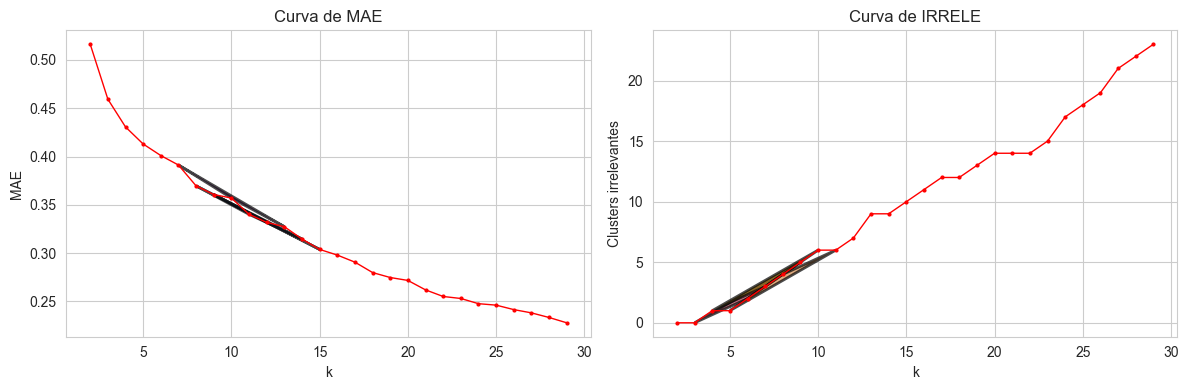

In [14]:
best_k = k_ISAC_TLP(k_values, MAE_values, irreleCluster_values)

## Aplicación de K-Means con el Número Óptimo de Clusters

In [15]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_final.fit(X)
labels = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_

## Guardar el Modelo Final

In [16]:
with open("pkls/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_final, f)